In [17]:
import numpy as np
from types import MethodType
from connectome.core.train_funcs import (
    preprocess_images,
    process_images,
    get_voronoi_averages,
    apply_inhibitory_r7_r8,
    get_activation_from_cell_type,
)
from connectome.core.voronoi_cells import VoronoiCells

# If present, capture the global data_processor for convenience
_dp_global = globals().get("data_processor", None)


def _compute_neuron_activations_from_image(img, vc, tesselated_neurons, voronoi_indices, inhibitory):
    """Return neuron activations DataFrame from a raw numpy image.
    Compatible with VoronoiCells.plot_neuron_activations expected schema.
    """
    img_pre = preprocess_images(np.expand_dims(img, 0))
    processed_img = process_images(img_pre, voronoi_indices)
    voronoi_average = get_voronoi_averages(processed_img)[0]
    voronoi_average.index = [vc.voronoi.point_region[int(i)] for i in voronoi_average.index]

    corr_tess = tesselated_neurons.copy()
    corr_tess["voronoi_indices"] = [vc.voronoi.point_region[int(i)] for i in corr_tess["voronoi_indices"]]
    neuron_acts = corr_tess.merge(voronoi_average, left_on="voronoi_indices", right_index=True)
    if inhibitory:
        neuron_acts = apply_inhibitory_r7_r8(neuron_acts)
    neuron_acts["activation"] = neuron_acts.apply(get_activation_from_cell_type, axis=1)
    return neuron_acts


# Monkey-patch VoronoiCells.plot_neuron_activations to accept numpy arrays (images)
if not hasattr(VoronoiCells, "_orig_plot_neuron_activations"):
    VoronoiCells._orig_plot_neuron_activations = VoronoiCells.plot_neuron_activations

    def _patched_plot_neuron_activations(self, n_acts, ax, voronoi_color="orange", volonoi_width=1):
        # If a raw image (numpy array) is passed, convert to neuron activations DF
        if isinstance(n_acts, np.ndarray):
            if _dp_global is not None:
                tesselated_neurons = _dp_global.tesselated_neurons
                voronoi_indices = _dp_global.voronoi_indices
                inhibitory = getattr(_dp_global, "inhibitory_r7_r8", False)
            else:
                tesselated_neurons = self.get_tesselated_neurons()
                voronoi_indices = self.get_image_indices()
                inhibitory = False
            n_acts = _compute_neuron_activations_from_image(
                n_acts, self, tesselated_neurons, voronoi_indices, inhibitory
            )
        return VoronoiCells._orig_plot_neuron_activations(
            self, n_acts, ax, voronoi_color, volonoi_width
        )

    VoronoiCells.plot_neuron_activations = _patched_plot_neuron_activations


# Add data_processor.plot_neuron_activations if a global data_processor exists
if _dp_global is not None and not hasattr(_dp_global, "plot_neuron_activations"):
    def _dp_plot_neuron_activations(self, img, ax, voronoi_color="orange", voronoi_width=1):
        # Use FlyPlotter internals to plot directly from a raw image
        return self.plotter._plot_neuron_activations(
            img,
            ax,
            self.tesselated_neurons,
            self.voronoi_indices,
            self.inhibitory_r7_r8,
            voronoi_color,
            voronoi_width,
        )

    _dp_global.plot_neuron_activations = MethodType(_dp_plot_neuron_activations, _dp_global)

# Ensure input image uses same coordinate convention as Voronoi skeleton
if not hasattr(VoronoiCells, "_orig_plot_input_image"):
    VoronoiCells._orig_plot_input_image = VoronoiCells.plot_input_image

    def _patched_plot_input_image(self, image, ax):
        ax.imshow(image, extent=[0, self.pixel_num, 0, self.pixel_num], origin="lower")
        ax.set_xticks([])
        ax.set_yticks([])
        ax.set_xticklabels([])
        ax.set_yticklabels([])

    VoronoiCells.plot_input_image = _patched_plot_input_image



In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt

import connectome

config = connectome.get_config()
from paths import PROJECT_ROOT

from connectome.core.utils import get_image_paths, select_random_images

from connectome.core.data_processing import DataProcessor

# Input activations

In [2]:
training_images = get_image_paths(os.path.join(PROJECT_ROOT, "images", "one_to_ten", "train", "blue"), 100)
data_processor = DataProcessor(config)

In [3]:
batch_files, already_selected = select_random_images(training_images, 100, [])
images, labels = data_processor.get_data_from_paths(batch_files)

In [ ]:
def add_jitter(plot_data, neuron_types, jitter_size):
    r8_mask = [a in neuron_types for a in plot_data["cell_type"]]
    x_choice = np.random.choice([-jitter_size, jitter_size], size=len(plot_data))
    y_choice = np.random.choice([-jitter_size, jitter_size], size=len(plot_data))
    plot_data.loc[r8_mask, "x_axis"] += x_choice[r8_mask]
    plot_data.loc[r8_mask, "y_axis"] += y_choice[r8_mask]
    return plot_data

def plot_voronoi_cells_with_neurons(self, neuron_data, ax):
    # Set black background
    ax.set_facecolor("black")

    # Modern color palette that pops on black:
    self.color_map = {
        "R1-6": "#ffffff", 
        "R7": "#1e90ff",  
        "R8p": "#50ff50",  
        "R8y": "#ff4d4d", 
    }

    plot_data = neuron_data.copy()

    jitter_size = 4

    r8_mask = [a in ["R8y", "R8p"] for a in plot_data["cell_type"]]

    # Generate random choices between x and y jitter for each point
    x_choice = np.random.choice([-jitter_size, jitter_size], size=len(plot_data))

    # Where xy_choice is 0, make yx_choice ±2
    y_choice = np.random.choice([-jitter_size, jitter_size], size=len(plot_data))

    # Apply jitter only to R8 neurons
    plot_data.loc[r8_mask, "x_axis"] += x_choice[r8_mask]
    plot_data.loc[r8_mask, "y_axis"] += y_choice[r8_mask]

    plot_data["color"] = plot_data["cell_type"].apply(lambda x: self.color_map[x])

    self._plot_voronoi_cells(ax, line_color=voronoi_color, line_width=voronoi_width)

    plot_data["y_axis"] = self.pixel_num - 1 - plot_data["y_axis"]

    # Plot neurons with improved visibility
    for cell_type, color in self.color_map.items():
        points = plot_data[plot_data["cell_type"] == cell_type]
        ax.scatter(
            points["x_axis"],
            points["y_axis"],
            color=color,
            s= 1 if cell_type == "R1-6" else 5,  
            alpha=0.8 if cell_type == "R1-6" else 1, 
            label=cell_type,
        )

    # Legend with white text
    legend = ax.legend(title="Cell Types", loc="lower right", frameon=True)
    legend.get_frame().set_facecolor("black")
    legend.get_frame().set_edgecolor("white")
    plt.setp(legend.get_texts(), color="white")
    plt.setp(legend.get_title(), color="white")

    self.clip_image(ax)

def plot_neurons_without_voronoi(data_processor, ax):
    # Set black background
    ax.set_facecolor("black")

    # Modern color palette that pops on black:
    data_processor.color_map = {
        "R1-6": "#ffffff", 
        "R7": "#1e90ff",  
        "R8p": "#50ff50",  
        "R8y": "#ff4d4d", 
    }

    plot_data = data_processor.tesselated_neurons.copy()

    plot_data["y_axis"] = data_processor.voronoi_cells.pixel_num - 1 - plot_data["y_axis"]

    plot_data = add_jitter(plot_data, ["R8y", "R8p"], 4)

    for cell_type, color in data_processor.color_map.items():
        points = plot_data[plot_data["cell_type"] == cell_type]
        ax.scatter(
            points["x_axis"],
            points["y_axis"],
            color=color,
            s= 1 if cell_type == "R1-6" else 5,  
            alpha=0.8 if cell_type == "R1-6" else 1, 
            label=cell_type,
        )
        
    data_processor.voronoi_cells.clip_image(ax)



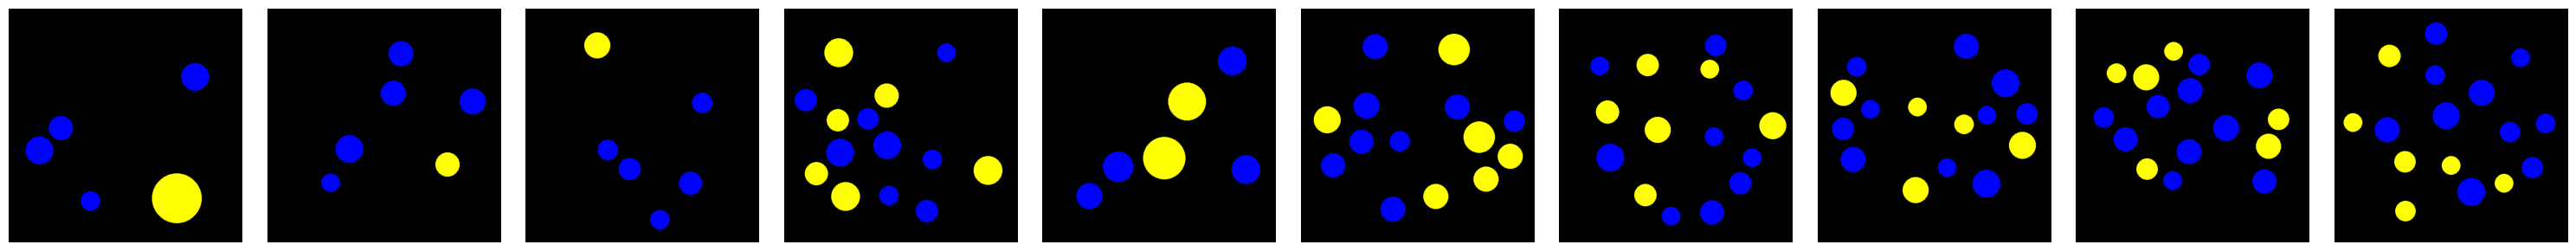

In [13]:
%matplotlib inline
# plot 10 input images side to side
plt.close("all")

fig, axes = plt.subplots(1, 10, figsize=(30, 3))   # one row, ten columns

for i, img in enumerate(images[60:70]):
    axes[i].imshow(img)
    axes[i].axis("off")

plt.tight_layout()
plt.show()

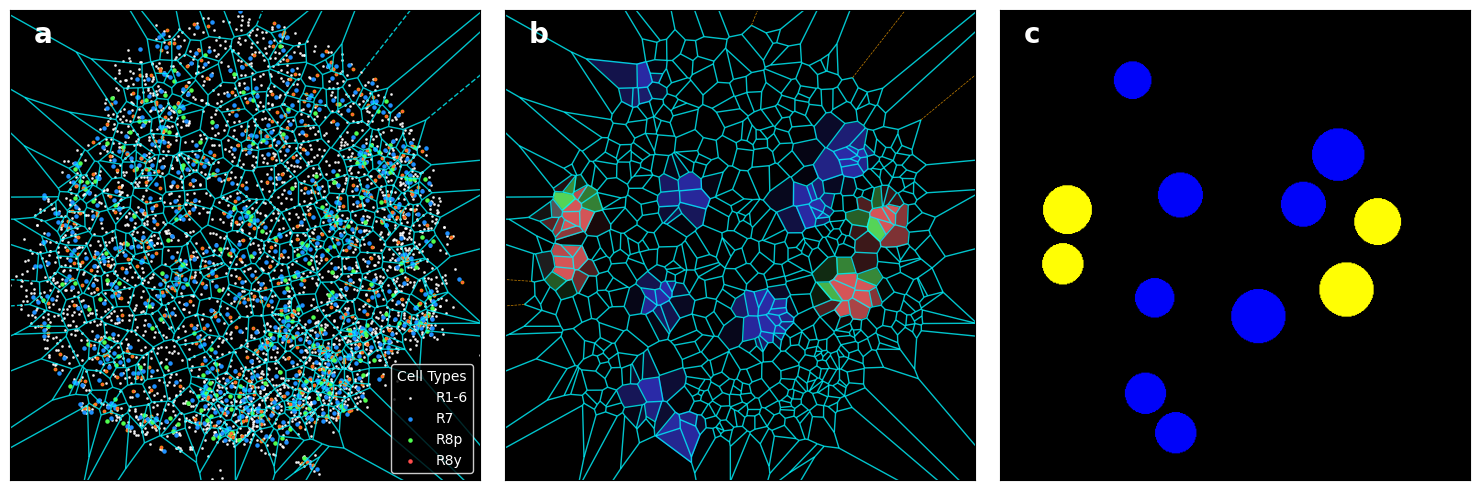

<Figure size 640x480 with 0 Axes>

In [21]:
%matplotlib inline

voronoi_color = "#00f5ff"
voronoi_width = 1


img = images[2]
plt.close("all")
fig, axes = plt.subplots(1, 3, figsize=(15, 5))
plot_voronoi_cells_with_neurons(
    data_processor.voronoi_cells, data_processor.tesselated_neurons, axes[0]
)
data_processor.voronoi_cells.plot_neuron_activations(img, axes[1], voronoi_color, voronoi_width)
data_processor.voronoi_cells.plot_input_image(img, axes[2])

# Add panel labels
for ax, label in zip(axes, ["a", "b", "c"]):
    ax.text(
        0.05,
        0.93,
        label,
        transform=ax.transAxes,
        fontsize=20,
        fontweight="bold",
        color="white",
    )

plt.tight_layout()
plt.show()
plt.savefig("../../plots/stripes.pdf", dpi=300, bbox_inches="tight")

In [10]:
import os

os.getcwd()

'/home/eudald/Escriptori/doctorat/connectome/notebooks/visualization'

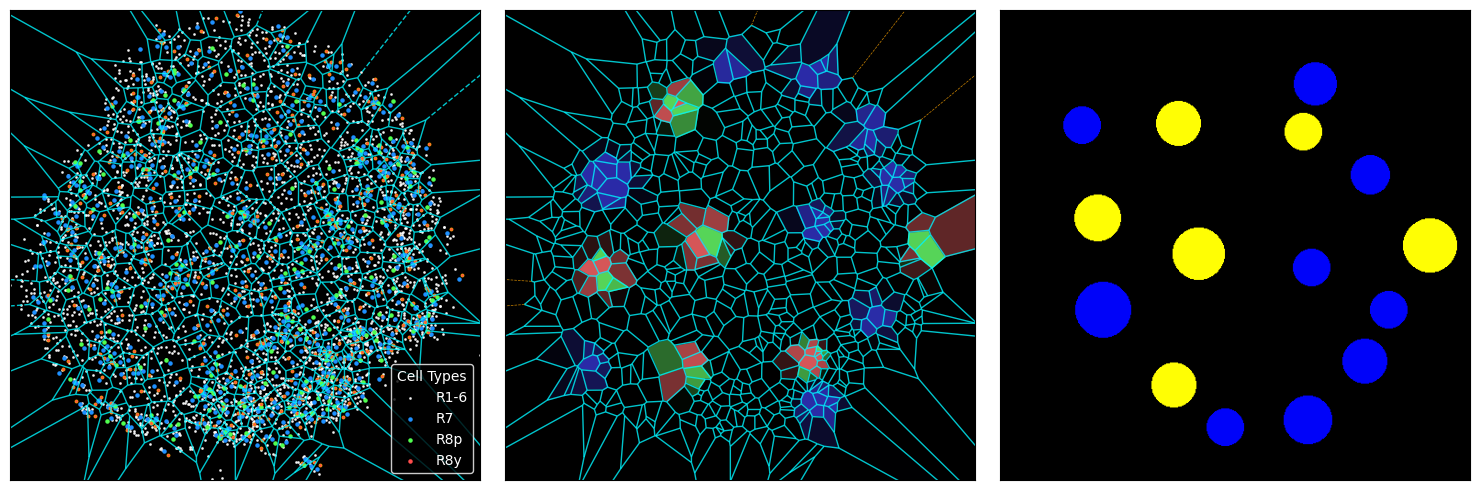

In [16]:
%matplotlib inline

voronoi_color = "#00f5ff"
voronoi_width = 1


img = good_image
plt.close("all")
fig, axes = plt.subplots(1, 3, figsize=(15, 5))
plot_voronoi_cells_with_neurons(
    data_processor.voronoi_cells, data_processor.tesselated_neurons, axes[0]
)
data_processor.plot_neuron_activations(img, axes[1], voronoi_color, voronoi_width)
data_processor.voronoi_cells.plot_input_image(img, axes[2])

# Add panel labels
"""for ax, label in zip(axes, ["a", "b", "c"]):
    ax.text(
        0.05,
        0.93,
        label,
        transform=ax.transAxes,
        fontsize=20,
        fontweight="bold",
        color="white",
    )"""

plt.tight_layout()
plt.show()
# plt.savefig("plots/stripes.pdf", dpi=300, bbox_inches="tight")

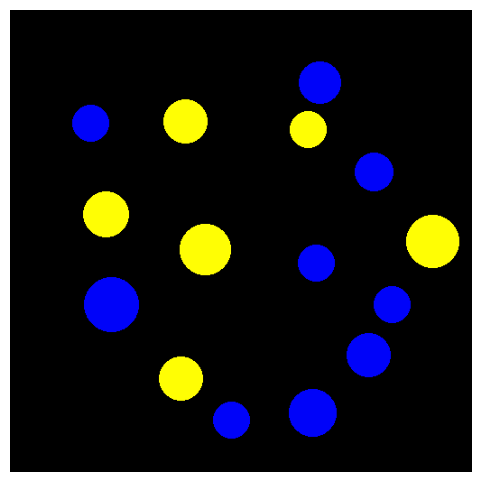

In [17]:
# plot the input image 5

plt.close("all")
img = good_image
plt.figure(figsize=(10, 6))
plt.imshow(img)
plt.axis("off")
plt.show()


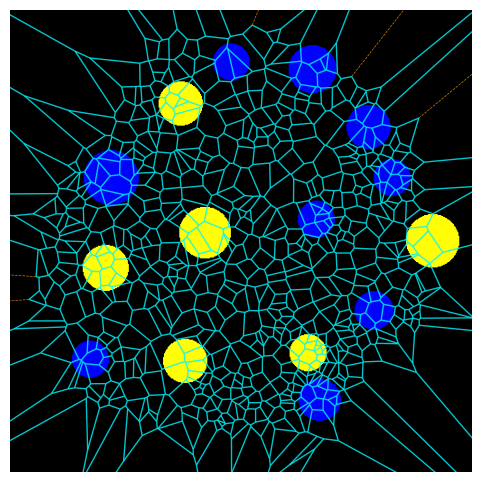

In [18]:
# plot input image 5 with the voronoi cells

plt.close("all")
img = good_image
fig, ax = plt.subplots(figsize=(10, 6))
data_processor.voronoi_cells._plot_voronoi_cells(ax, line_color=voronoi_color, line_width=voronoi_width)
ax.imshow(img)
ax.axis("off")
data_processor.voronoi_cells.clip_image(ax)
plt.show()




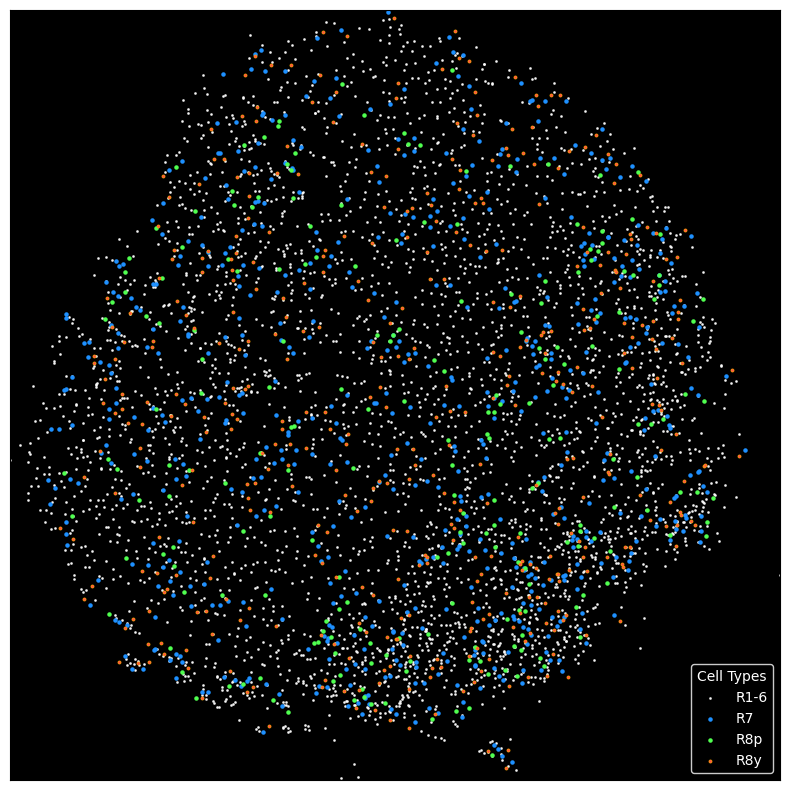

In [21]:
# plot the neurons without the voronoi cells

plt.close("all")
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111)
plot_neurons_without_voronoi(data_processor, ax)
# Legend with white text
legend = ax.legend(title="Cell Types", loc="lower right", frameon=True)
legend.get_frame().set_facecolor("black")
legend.get_frame().set_edgecolor("white")
plt.setp(legend.get_texts(), color="white")
plt.setp(legend.get_title(), color="white")

plt.show()

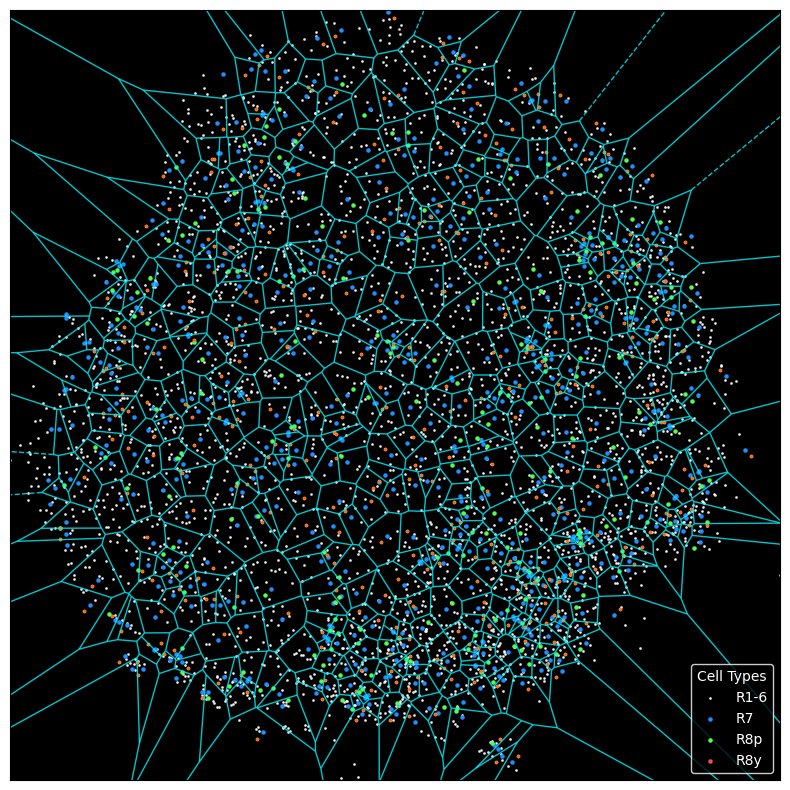

In [7]:
# plot only the first panel from the previous chunk

plt.close("all")
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111)
plot_voronoi_cells_with_neurons(
    data_processor.voronoi_cells, data_processor.tesselated_neurons, ax
)
plt.show()

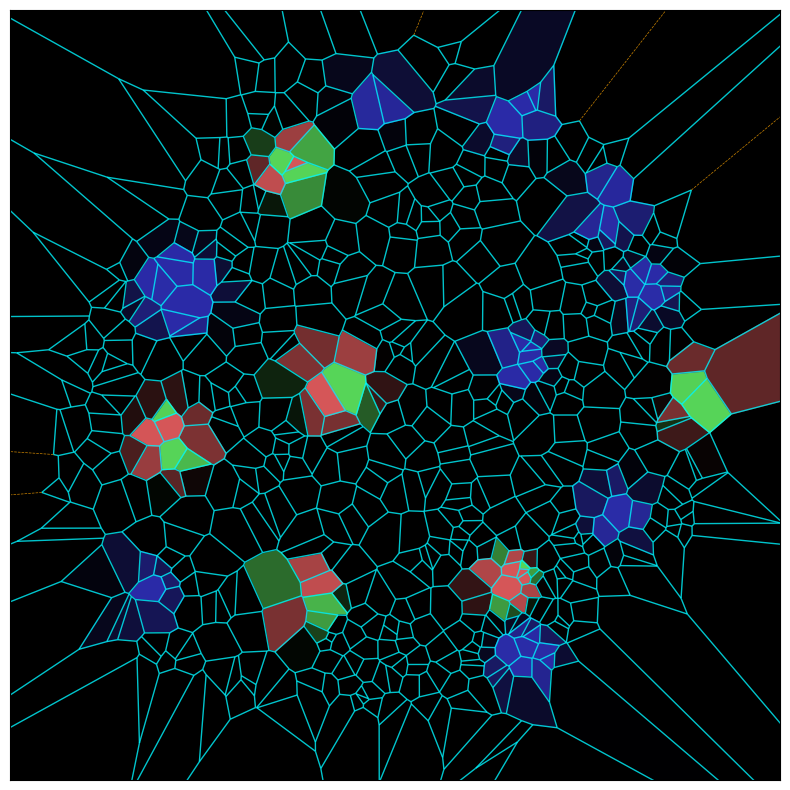

In [19]:
# re-import data


%matplotlib inline
img = good_image
plt.close("all")

# Second plot
plt.figure(figsize=(8, 8))
data_processor.plot_neuron_activations(img, plt.gca(), voronoi_color, voronoi_width)
plt.tight_layout()
plt.show()
# plt.savefig(os.path.join(PROJECT_ROOT, "plots/activations.svg"), dpi=1000, bbox_inches="tight")

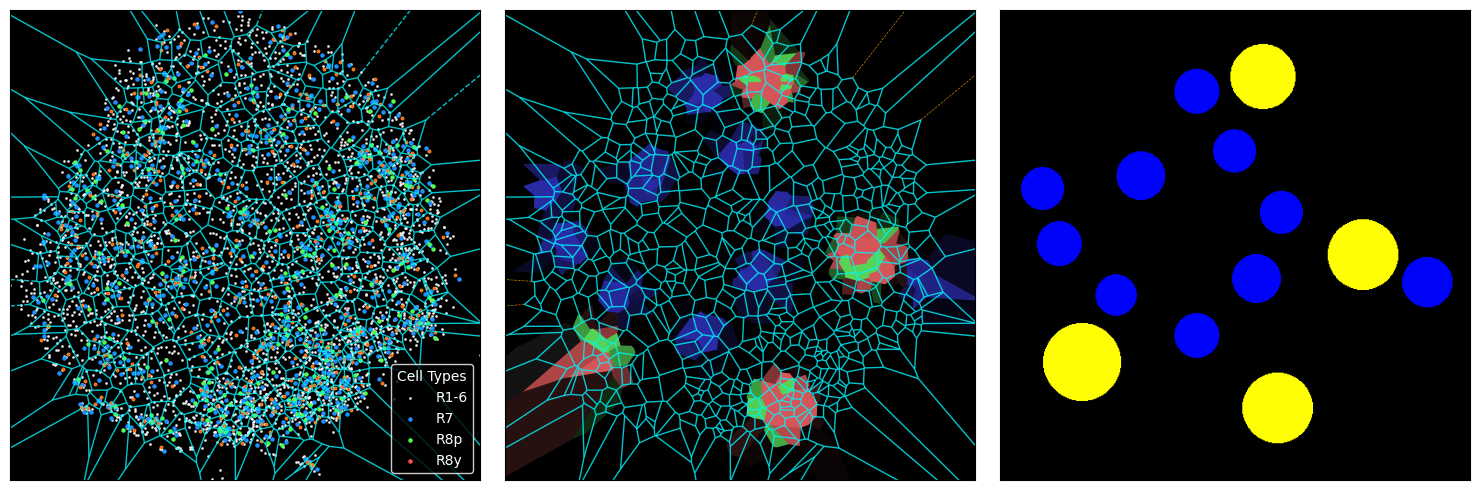

In [ ]:
%matplotlib inline

voronoi_color = "#00f5ff"
voronoi_width = 1


img = images[5]
plt.close("all")
fig, axes = plt.subplots(1, 3, figsize=(15, 5))
plot_voronoi_cells_with_neurons(
    data_processor.voronoi_cells, data_processor.tesselated_neurons, axes[0]
)
data_processor.plot_neuron_activations(img, axes[1], voronoi_color, voronoi_width)
data_processor.voronoi_cells.plot_input_image(img, axes[2])

# Add panel labels
"""for ax, label in zip(axes, ["a", "b", "c"]):
    ax.text(
        0.05,
        0.93,
        label,
        transform=ax.transAxes,
        fontsize=20,
        fontweight="bold",
        color="white",
    )"""

plt.tight_layout()
plt.show()
# plt.savefig("plots/stripes.pdf", dpi=300, bbox_inches="tight")

In [31]:
# Third plot
plt.figure(figsize=(8, 8))
data_processor.voronoi_cells.plot_input_image(img, plt.gca())
plt.tight_layout()
plt.savefig("plots/input_image.png", dpi=1000, bbox_inches="tight")

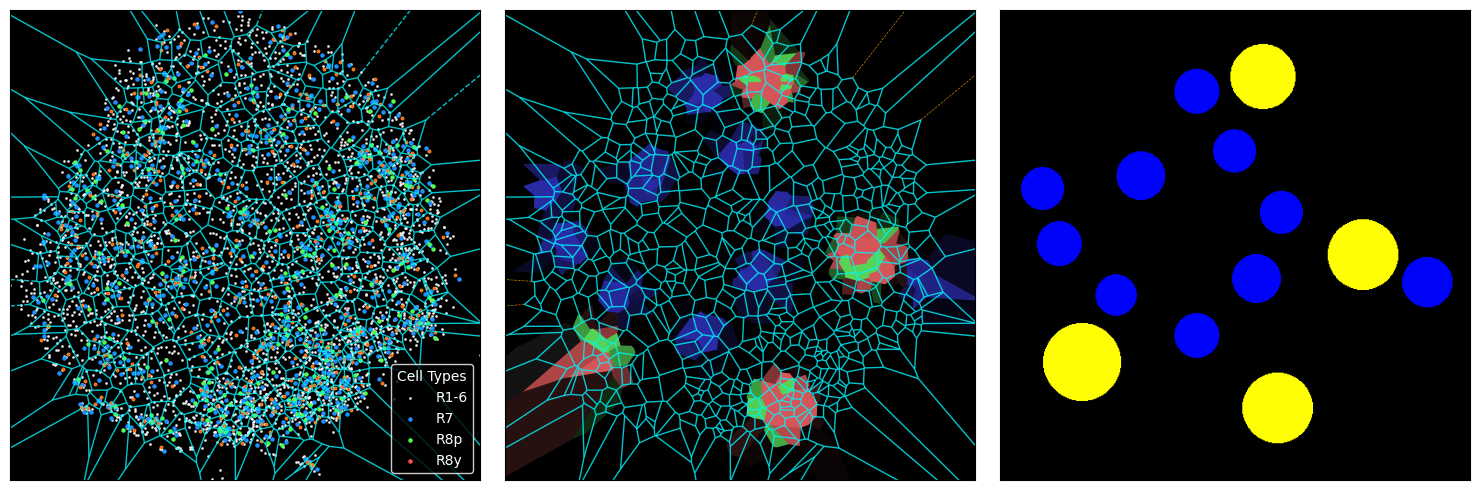

In [ ]:
%matplotlib inline

voronoi_color = "#00f5ff"
voronoi_width = 1


img = images[5]
plt.close("all")
fig, axes = plt.subplots(1, 3, figsize=(15, 5))
plot_voronoi_cells_with_neurons(
    data_processor.voronoi_cells, data_processor.tesselated_neurons, axes[0]
)
data_processor.plot_neuron_activations(img, axes[1], voronoi_color, voronoi_width)
data_processor.voronoi_cells.plot_input_image(img, axes[2])

# Add panel labels
"""for ax, label in zip(axes, ["a", "b", "c"]):
    ax.text(
        0.05,
        0.93,
        label,
        transform=ax.transAxes,
        fontsize=20,
        fontweight="bold",
        color="white",
    )"""

plt.tight_layout()
plt.show()
# plt.savefig("plots/stripes.pdf", dpi=300, bbox_inches="tight")

In [3]:
from paths import PROJECT_ROOT

training_images = get_image_paths(os.path.join(PROJECT_ROOT, "images", "two_shapes3", "train", "star"), 10)
data_processor1 = DataProcessor(config)
batch_files, already_selected = select_random_images(training_images, 10, [])
images1, labels = data_processor1.get_data_from_paths(batch_files, get_labels=False)


training_images = get_image_paths(os.path.join(PROJECT_ROOT, "images", "two_colors", "train", "blue"), 10)
data_processor2 = DataProcessor(config)
data_processor2.classes = ["blue", "yellow"]
batch_files, already_selected = select_random_images(training_images, 10, [])
images2, labels = data_processor2.get_data_from_paths(batch_files, get_labels=False)

In [4]:
img1 = images1[0]
img2 = images2[1]

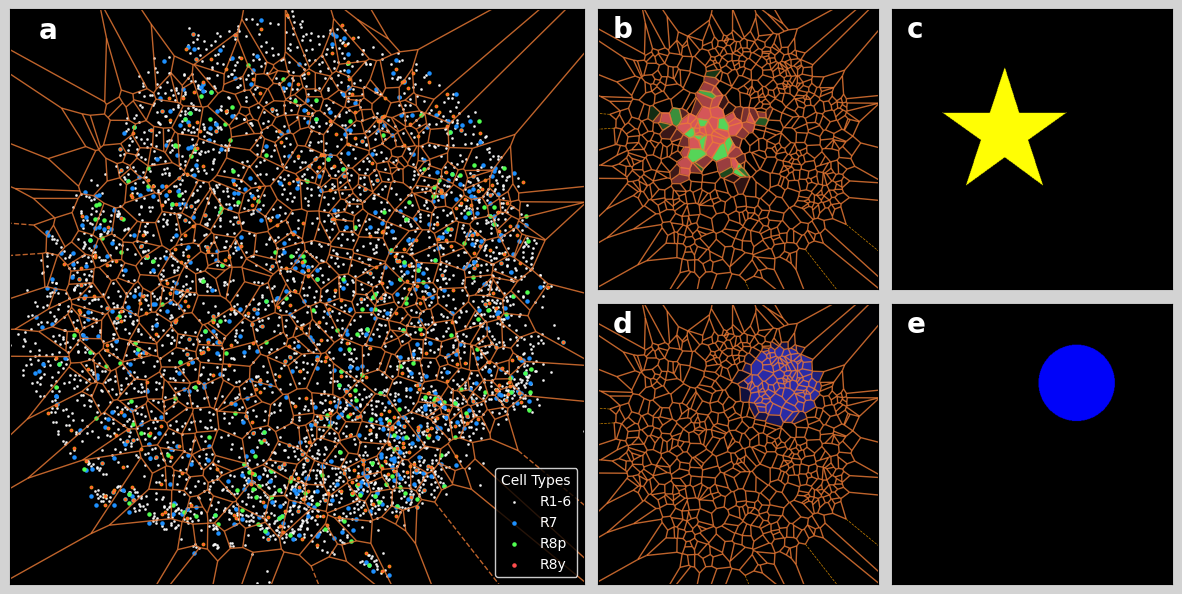

In [29]:
voronoi_color = "#ee7c36"
voronoi_width = 1


%matplotlib inline
plt.close("all")
fig = plt.figure(figsize=(15, 10))
fig.patch.set_facecolor('#d3d3d3')
gs = fig.add_gridspec(2, 4, height_ratios=[1, 1], width_ratios=[1, 1, 1, 1], 
                     hspace=-0.38, wspace=0.05,)
                     #left=0.05, right=0.95, top=0.95, bottom=0.05)

ax1 = fig.add_subplot(gs[0:2, 0:2])
ax2 = fig.add_subplot(gs[0, 2])    
ax3 = fig.add_subplot(gs[0, 3])
ax4 = fig.add_subplot(gs[1, 2])    
ax5 = fig.add_subplot(gs[1, 3]) 

axes = [ax1, ax2, ax3, ax4, ax5]

# First row - original image
plot_voronoi_cells_with_neurons(
    data_processor1.voronoi_cells, data_processor1.tesselated_neurons, ax1
)
data_processor1.plot_neuron_activations(img1, ax2, voronoi_color, voronoi_width)
data_processor1.voronoi_cells.plot_input_image(img1, ax3)

# Second row - new image
data_processor2.plot_neuron_activations(img2, ax4, voronoi_color, voronoi_width)
data_processor2.voronoi_cells.plot_input_image(img2, ax5)

# Add panel labels to all subplots
labels = ["a", "b", "c", "d", "e"]
for ax, label in zip(axes, ["a", "b", "c", "d", "e"]):
    ax.text(
        0.05,
        0.95 if label == "a" else 0.9,
        label,
        transform=ax.transAxes,
        fontsize=20,
        fontweight="bold",
        color="white",
    )

# plt.tight_layout()
# plt.show()
plt.savefig(os.path.join(PROJECT_ROOT, "plots", "input_tesselation.pdf"), dpi=300, bbox_inches="tight")
plt.savefig(os.path.join(PROJECT_ROOT, "plots", "input_tesselation.png"), dpi=300, bbox_inches="tight")


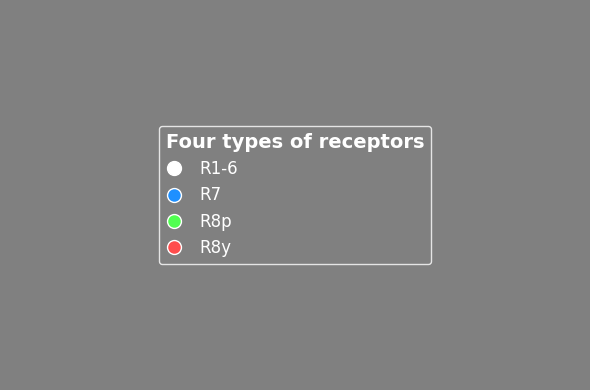

In [12]:
# only the legend
%matplotlib inline
plt.close("all")
import matplotlib.pyplot as plt
import matplotlib.lines as mlines

# Crear figura i eix
fig, ax = plt.subplots(figsize=(6, 4))

# Fons negre
ax.set_facecolor("gray")
fig.patch.set_facecolor("gray")

# Color map igual que el teu
color_map = {
    "R1-6": "#ffffff",  # Bright mint
    "R7": "#1e90ff",    # Bright rose
    "R8p": "#50ff50",   # Bright gold
    "R8y": "#ff4d4d",   # Bright cyan
}

# Crear elements dummy per la llegenda amb punts més grans
legend_elements = []
for cell_type, color in color_map.items():
    # Crear marcadors amb mida més gran (markersize=10)
    legend_elements.append(
        mlines.Line2D([0], [0], marker='o', color='w', 
                     markerfacecolor=color, markersize=10, 
                     label=cell_type, linestyle='None')
    )

# Crear la llegenda
legend = ax.legend(handles=legend_elements, title="Four types of receptors", 
                  loc="center", frameon=True, fontsize=12,
                  handletextpad=1,  # Espai entre marcador i text
                  handlelength=1.0,   # Longitud del marcador
                  columnspacing=1.0,  # Espai entre columnes
                  alignment='left') 

# Configurar l'estil de la llegenda
legend.get_frame().set_facecolor("gray")
legend.get_frame().set_edgecolor("white")
plt.setp(legend.get_texts(), color="white")
plt.setp(legend.get_title(), color="white", fontsize=14, fontweight='bold')

# Amagar tots els elements del gràfic excepte la llegenda
ax.set_xlim(0, 1)
ax.set_ylim(0, 1)
ax.axis('off')  # Amagar eixos

# Ajustar el layout perquè la llegenda sigui centrada
plt.tight_layout()
plt.show()

# ANS results

In [30]:
import os

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme(font_scale=1.4)

In [47]:
df = pd.read_csv(os.path.join(PROJECT_ROOT, "supplementary_data", "one_to_ten2.csv"))

In [4]:
def plot_weber_fraction(results_df: pd.DataFrame) -> plt.Figure:
    # Calculate the percentage of correct answers for each Weber ratio
    results_df["yellow"] = results_df["Image"].apply(
        lambda x: os.path.basename(x).split("_")[1]
    )
    results_df["blue"] = results_df["Image"].apply(
        lambda x: os.path.basename(x).split("_")[2]
    )
    try:
        results_df["weber_ratio"] = results_df.apply(
            lambda row: max(int(row["yellow"]), int(row["blue"]))
            / min(int(row["yellow"]), int(row["blue"])),
            axis=1,
        )
    except ZeroDivisionError:
        results_df["weber_ratio"] = 0
    results_df["equalized"] = results_df["Image"].apply(
        lambda x: "equalized" in os.path.basename(x).lower()
    )

    correct_percentage = (
        results_df.groupby(["weber_ratio", "equalized"])["Is correct"].mean() * 100
    )
    correct_percentage = correct_percentage.reset_index()
    # because matplotlib is very stupid:
    correct_percentage["weber_ratio"] = correct_percentage["weber_ratio"].round(3)

    # Plot
    fig = plt.figure(figsize=(10, 6))
    sns.barplot(
        x="weber_ratio", y="Is correct", hue="equalized", data=correct_percentage
    )
    plt.xlabel("Weber Ratio")
    plt.ylabel("Percentage of Correct Answers")
    plt.title("Correct Classification by Weber Ratio and Image Equalization")
    plt.tight_layout()

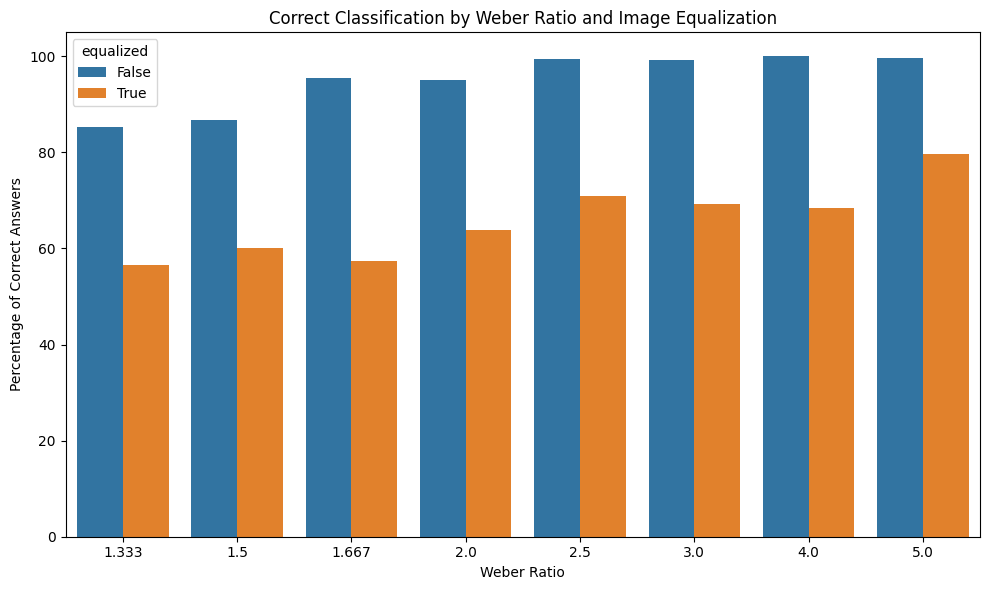

In [9]:
plot_weber_fraction(df)
plt.savefig("plots/weber_fraction.png", dpi=300, bbox_inches="tight")

In [55]:
def plot_weber_fraction(results_df: pd.DataFrame, save_path: str = None, min_weber = None) -> plt.Figure:
    """
    Create a publication-quality plot showing classification accuracy by Weber ratio.

    Args:
        results_df (pd.DataFrame): DataFrame containing the experimental results
        save_path (str, optional): Path to save the figure

    Returns:
        plt.Figure: The generated figure object
    """

    font_size = 12

    # Data preparation
    results_df["yellow"] = results_df["Image"].apply(
        lambda x: os.path.basename(x).split("_")[1]
    )
    results_df["blue"] = results_df["Image"].apply(
        lambda x: os.path.basename(x).split("_")[2]
    )

    # Calculate Weber ratio with error handling
    try:
        results_df["weber_ratio"] = results_df.apply(
            lambda row: max(int(row["yellow"]), int(row["blue"]))
            / min(int(row["yellow"]), int(row["blue"])),
            axis=1,
        )
    except ZeroDivisionError:
        results_df["weber_ratio"] = 0

    results_df["equalized"] = results_df["Image"].apply(
        lambda x: "equalized" in os.path.basename(x).lower()
    )

    # Calculate mean and standard error
    correct_percentage = (
        results_df.groupby(["weber_ratio", "equalized"])["Is correct"]
        .agg(["mean", "std", "count"])
        .reset_index()
    )
    correct_percentage["mean"] *= 100
    correct_percentage["std"] *= 100
    correct_percentage["se"] = correct_percentage["std"] / np.sqrt(
        correct_percentage["count"]
    )
    correct_percentage["weber_ratio"] = correct_percentage["weber_ratio"].round(3)

    # filter weber rations bigger than min_weber
    if min_weber is not None:
        correct_percentage = correct_percentage[correct_percentage["weber_ratio"] >= min_weber]

    # Set style for publication
    plt.style.use("seaborn-v0_8-white")

    # Create figure with Nature-compatible dimensions
    # Nature requires figures to be 89 mm or 183 mm wide
    width_mm = 183
    width_inches = width_mm / 25.4
    height_inches = width_inches * 0.75  # Using golden ratio
    fig, ax = plt.subplots(figsize=(width_inches, height_inches), dpi=300)

    # Plot data points and error bars
    conditions = [False, True]
    labels = ["Non-equalized", "Surface-equalized"]
    colors = ["#2166AC", "#B2182B"]  # Colorblind-friendly palette

    for condition, label, color in zip(conditions, labels, colors):
        data = correct_percentage[correct_percentage["equalized"] == condition]
        ax.errorbar(
            data["weber_ratio"],
            data["mean"],
            yerr=data["se"],
            label=label,
            color=color,
            marker="o",
            markersize=5,
            capsize=3,
            capthick=1,
            linewidth=1.5,
            linestyle="-",
        )

    # Customize appearance
    ax.set_xlabel("Weber Ratio", fontsize=font_size)
    ax.set_ylabel("Classification Accuracy (%)", fontsize=font_size)
    ax.tick_params(axis="both", which="major", labelsize=font_size)
    ax.spines[["right", "top"]].set_visible(False)

    # Add legend
    ax.legend(fontsize=font_size, frameon=False, loc="lower right")

    # Set y-axis limits with some padding
    ax.set_ylim(40, 105)

    # Add grid
    ax.yaxis.grid(True, linestyle="--", alpha=0.3)

    # Adjust layout
    plt.tight_layout()

    # Save if path provided
    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches="tight")

    return fig

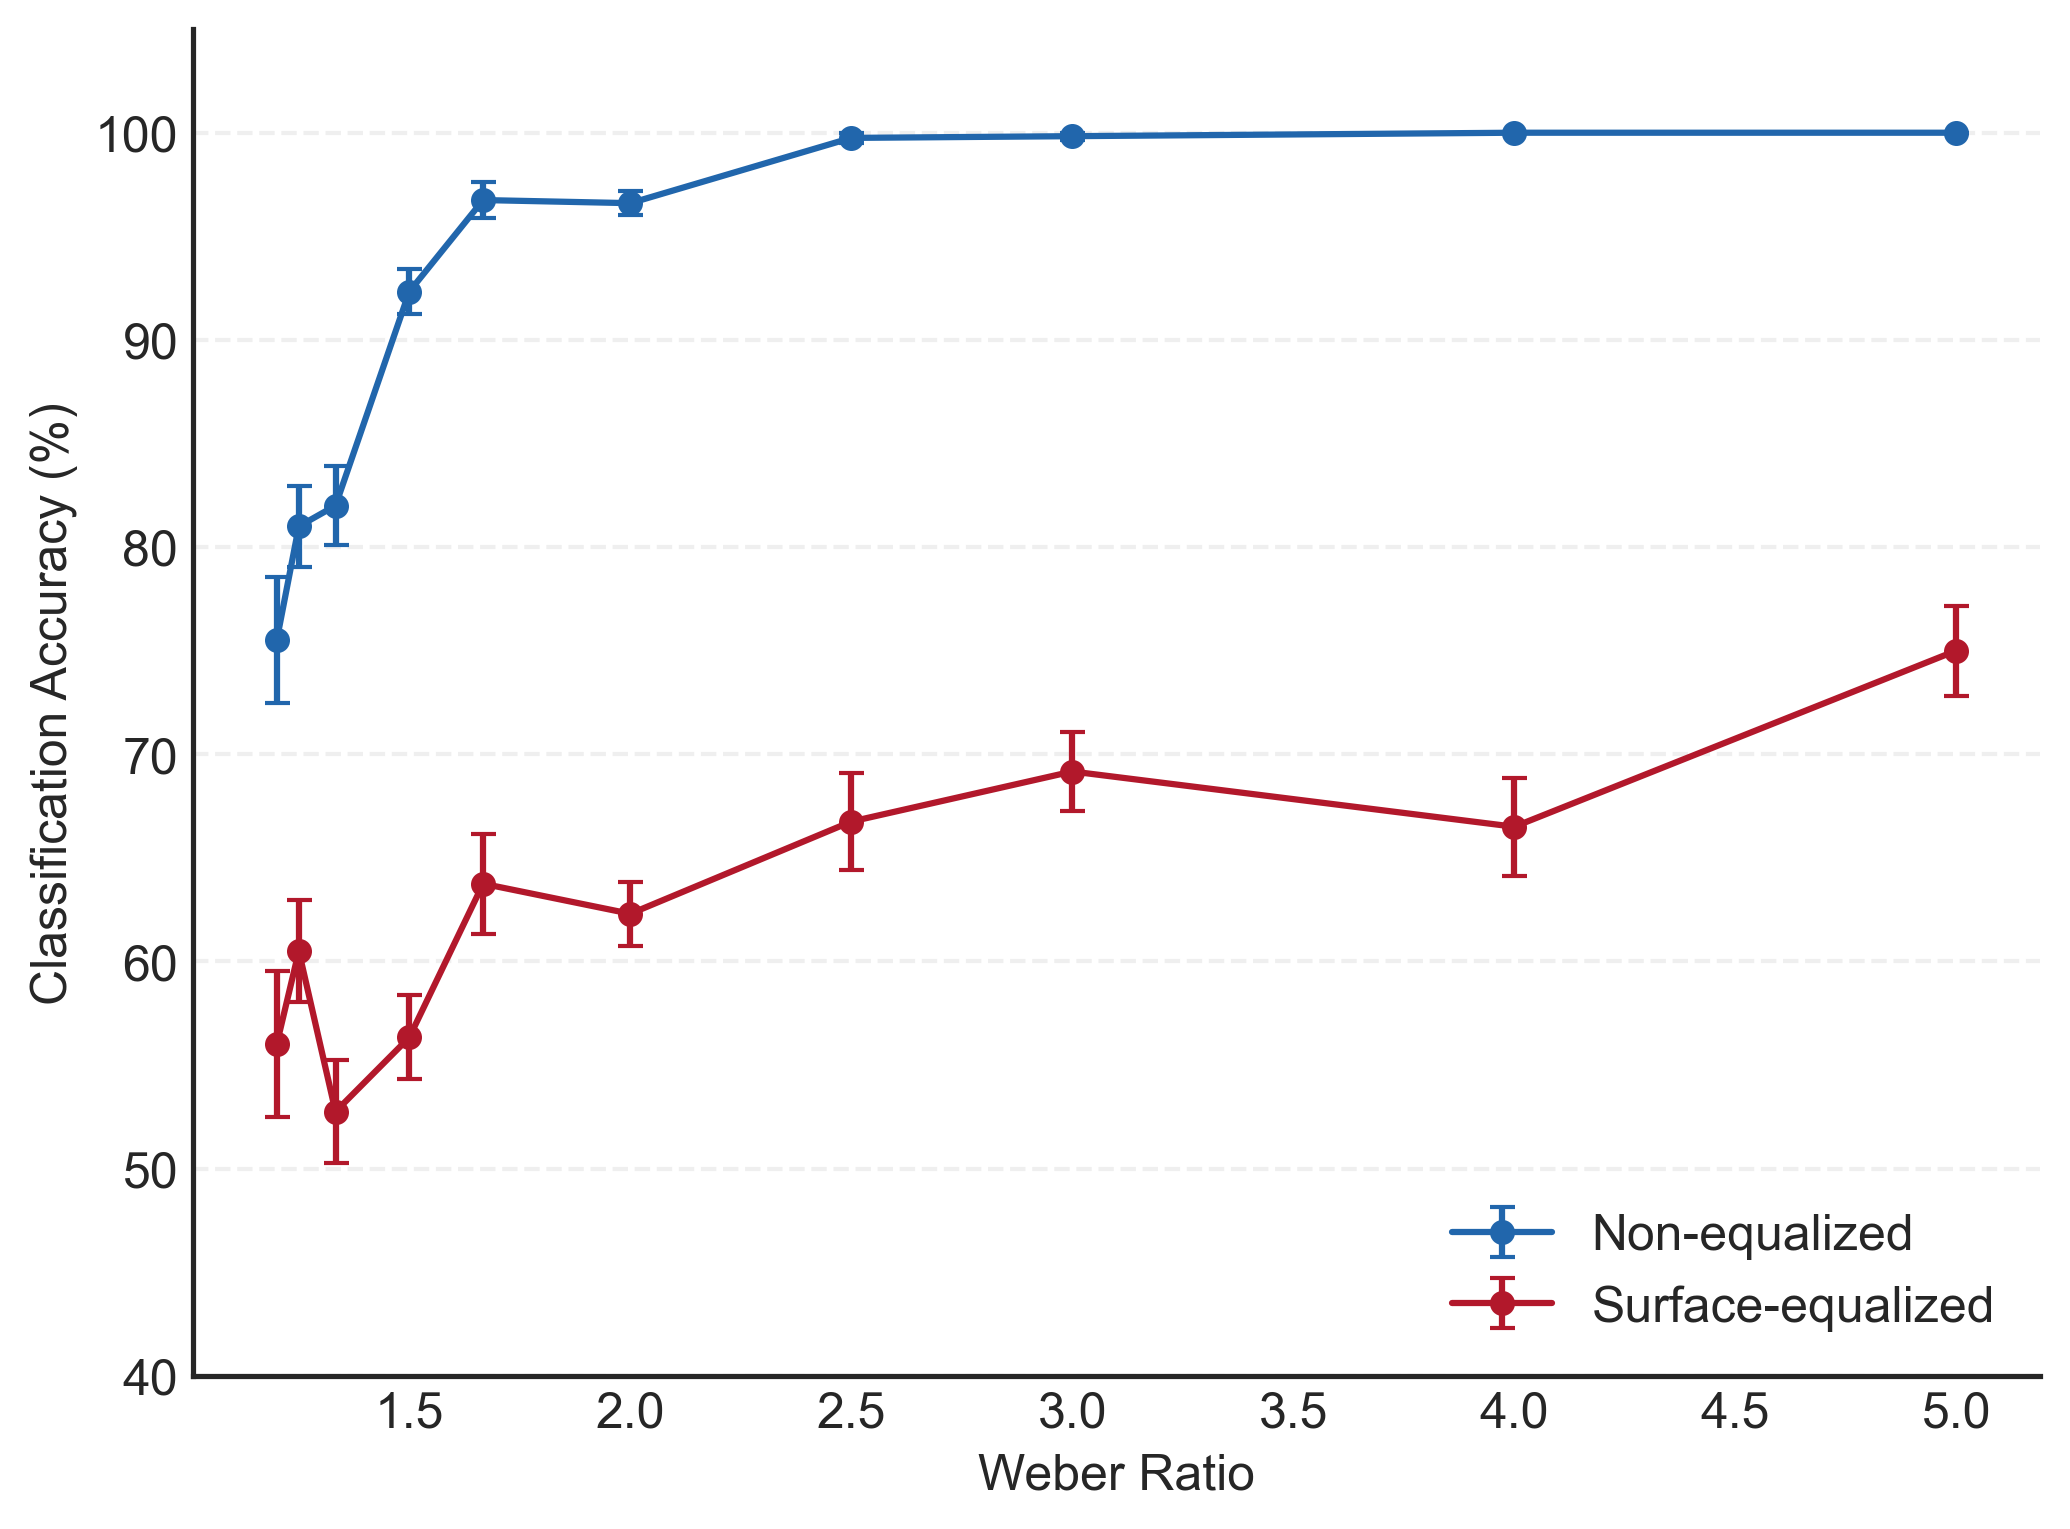

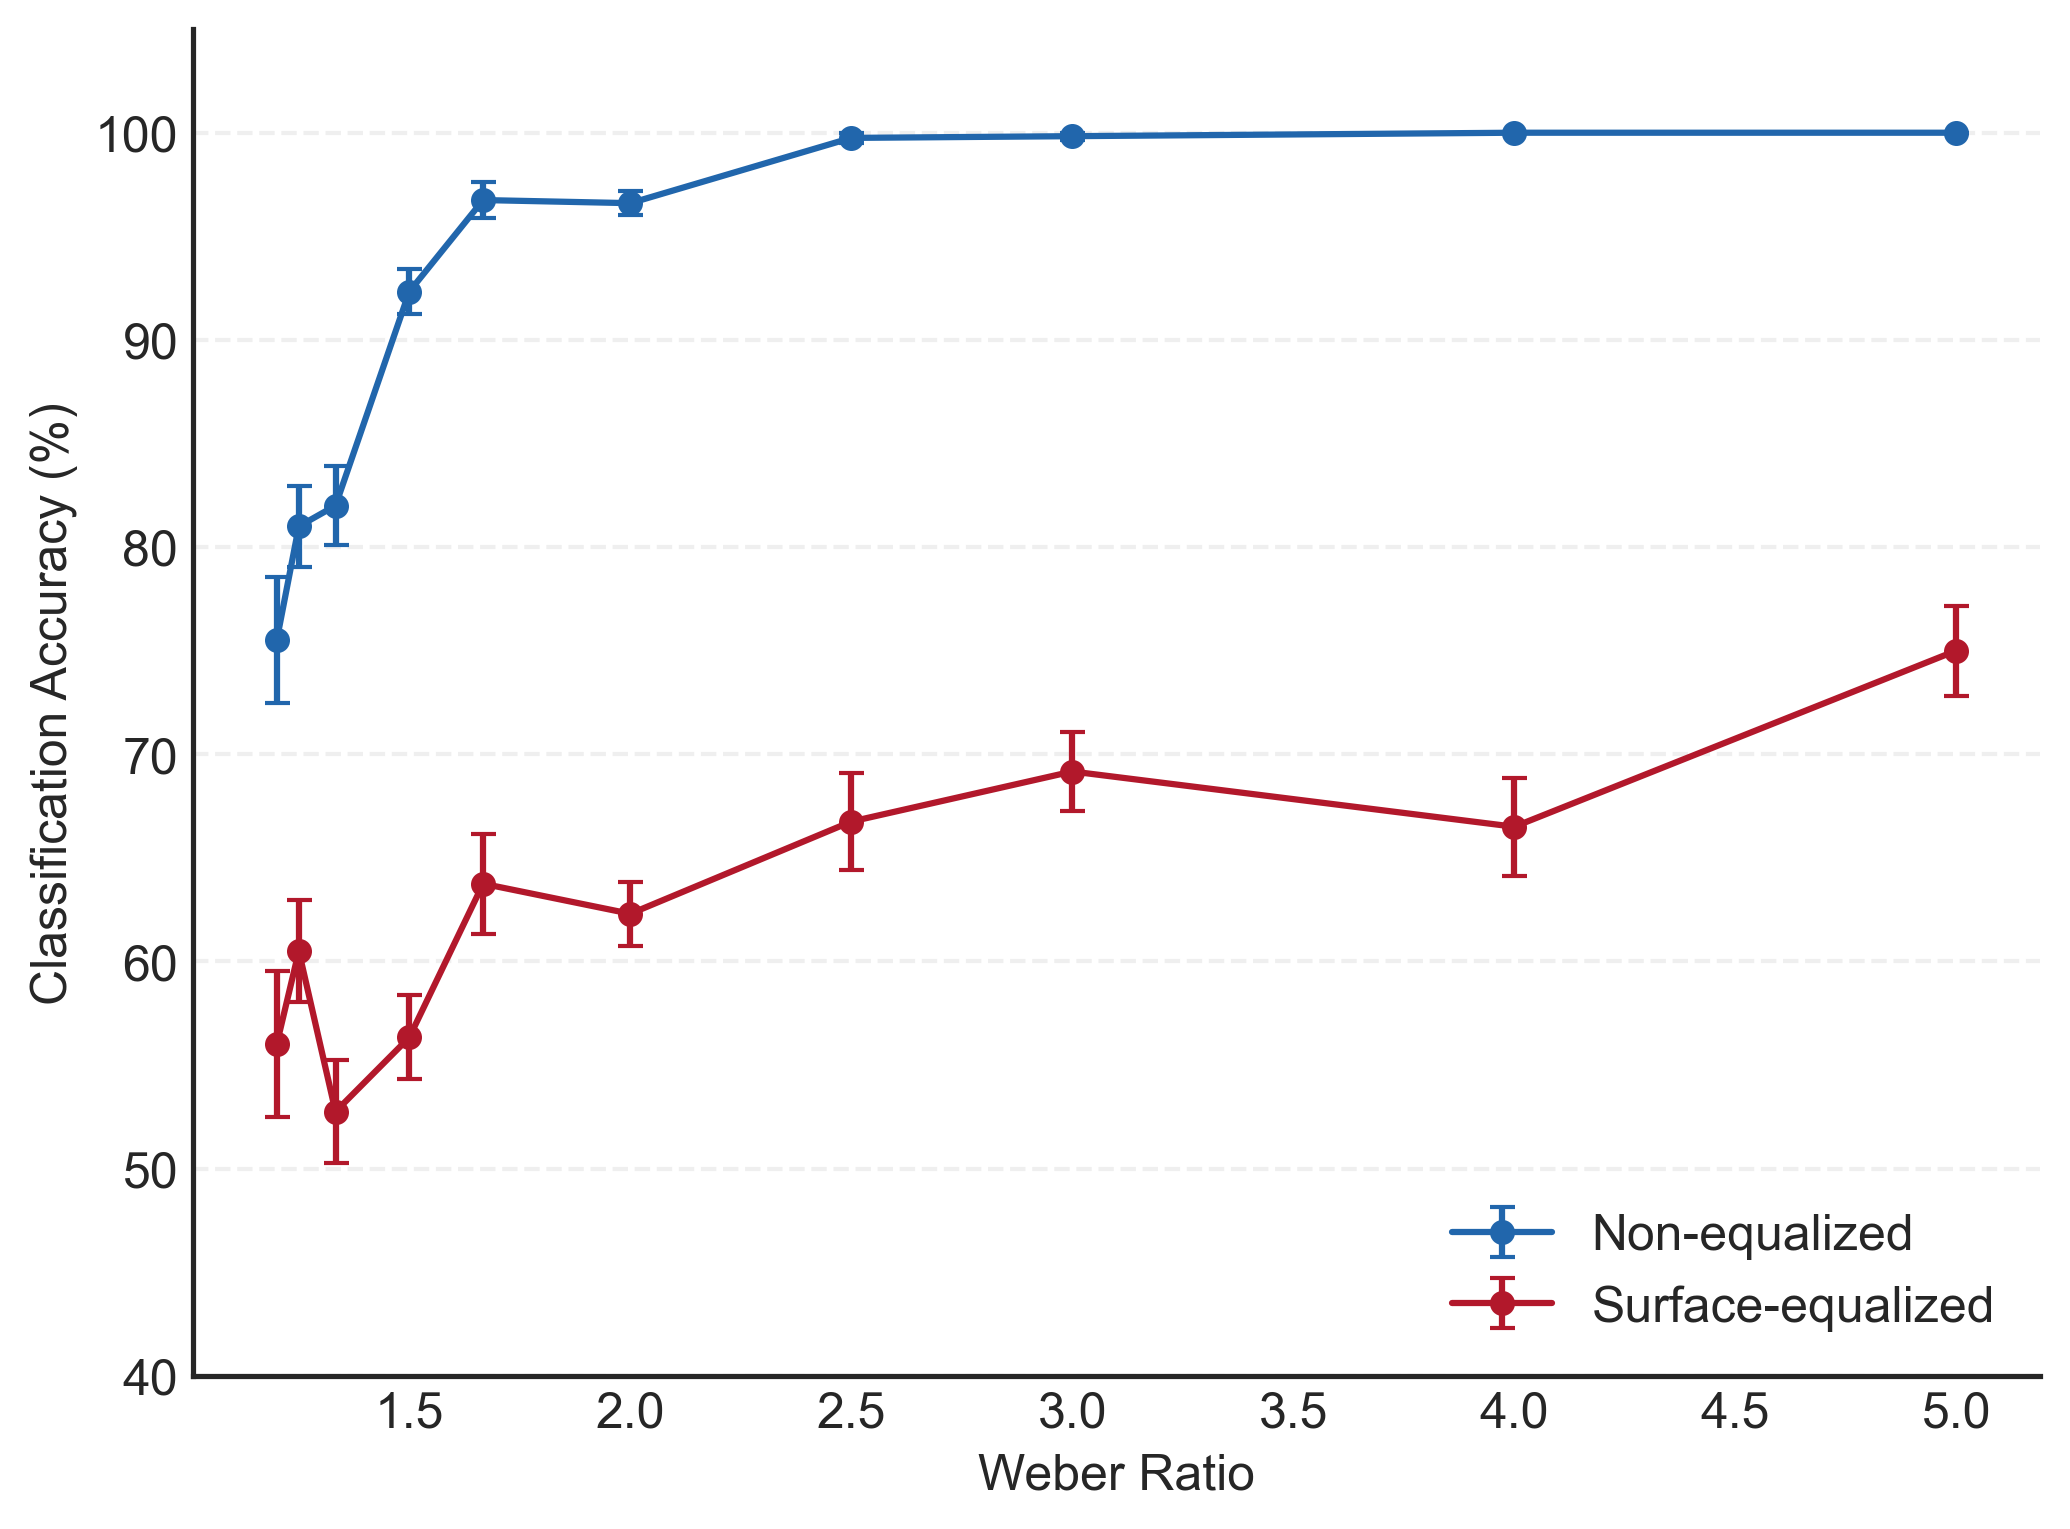

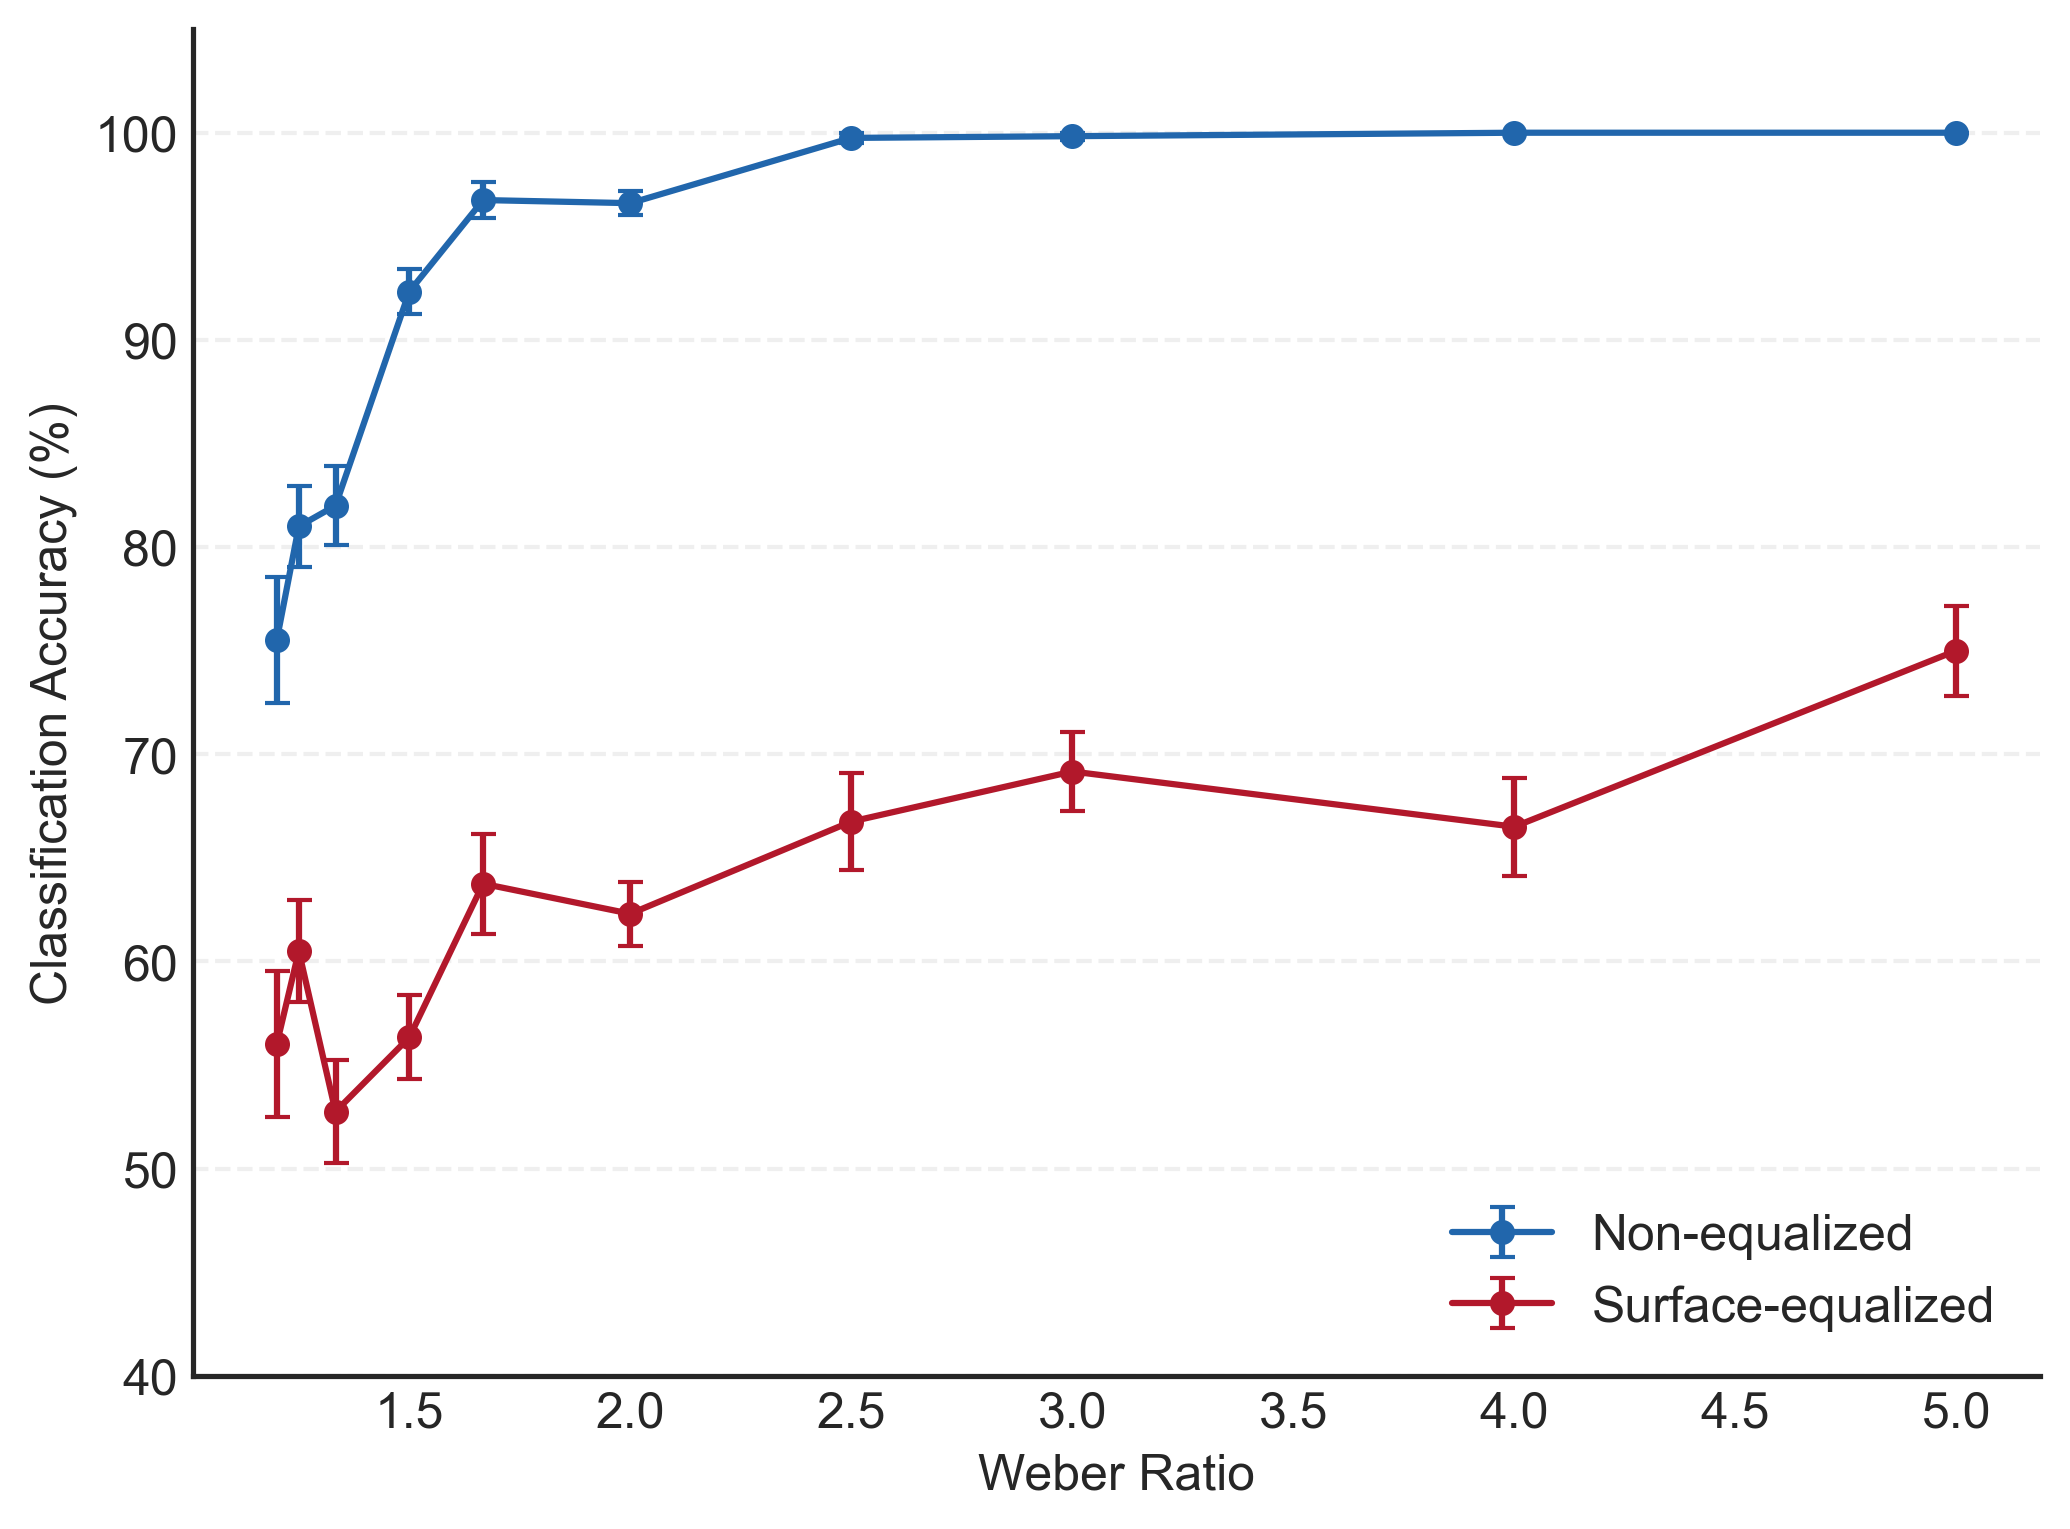

In [56]:
plot_weber_fraction(df, os.path.join(PROJECT_ROOT, "plots", "weber_fraction.pdf"), min_weber=1.2)
plot_weber_fraction(df, os.path.join(PROJECT_ROOT, "plots", "weber_fraction.pNG"), min_weber=1.2)

In [39]:
df.weber_ratio.value_counts()

weber_ratio
2.000000    2000
1.500000    1200
3.000000    1200
4.000000     800
1.250000     800
1.333333     800
1.666667     800
5.000000     800
2.500000     800
1.142857     400
1.111111     400
1.125000     400
1.200000     400
Name: count, dtype: int64